In [17]:
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt
import pandas as pd

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [18]:
def grid_sampling(num_points, bounds):
        """
        Generates Grid sampled data
        
        Parameters
        ----------
        num_points: int, number of points in LHS, should be greater than # of dimensions
        bounds: ndarray, array containing upper and lower bounds of elements in LHS sample. Defaults of 0 and 1
        
        Returns:
        ----------
        grid_data: ndarray, (num_points)**bounds.shape[1] grid sample of data
        
        """
        #Generate mesh_grid data for theta_set in 2D
        #Define linspace for theta
        params = np.linspace(0,1, num_points)
        #Define dimensions of parameter
        dimensions = bounds.shape[1]
        #Generate the equivalent of all meshgrid points
        df = pd.DataFrame(list(itertools.product(params, repeat=dimensions)))
        df2 = df.drop_duplicates()
        scaled_data = df2.to_numpy()
        #Normalize to bounds 
        lower_bound = bounds[0]
        upper_bound = bounds[1]
        grid_data = scaled_data*(upper_bound - lower_bound) + lower_bound 
        return grid_data

def calc_mm_model(true_model_coefficients, x, args = None):
    """
    Calculates the value of y for case study 1
    
    Parameters
    ----------
    true_model_coefficients: ndarray, The array containing the true values of Theta1 and Theta2
    x: ndarray, The list of xs that will be used to generate y
    args: dict, extra arguments to pass to the function. Default None
    
    Returns
    --------
    y_poly: ndarray, The noiseless values of y given theta_true and x
    """
    t1, t2 = true_model_coefficients
    y_poly =  t1*(1-np.exp(-t2*x))
    
    return y_poly

[ 7.88033994 13.1776608  15.99267208 17.47779992 18.25231305 18.66997265]


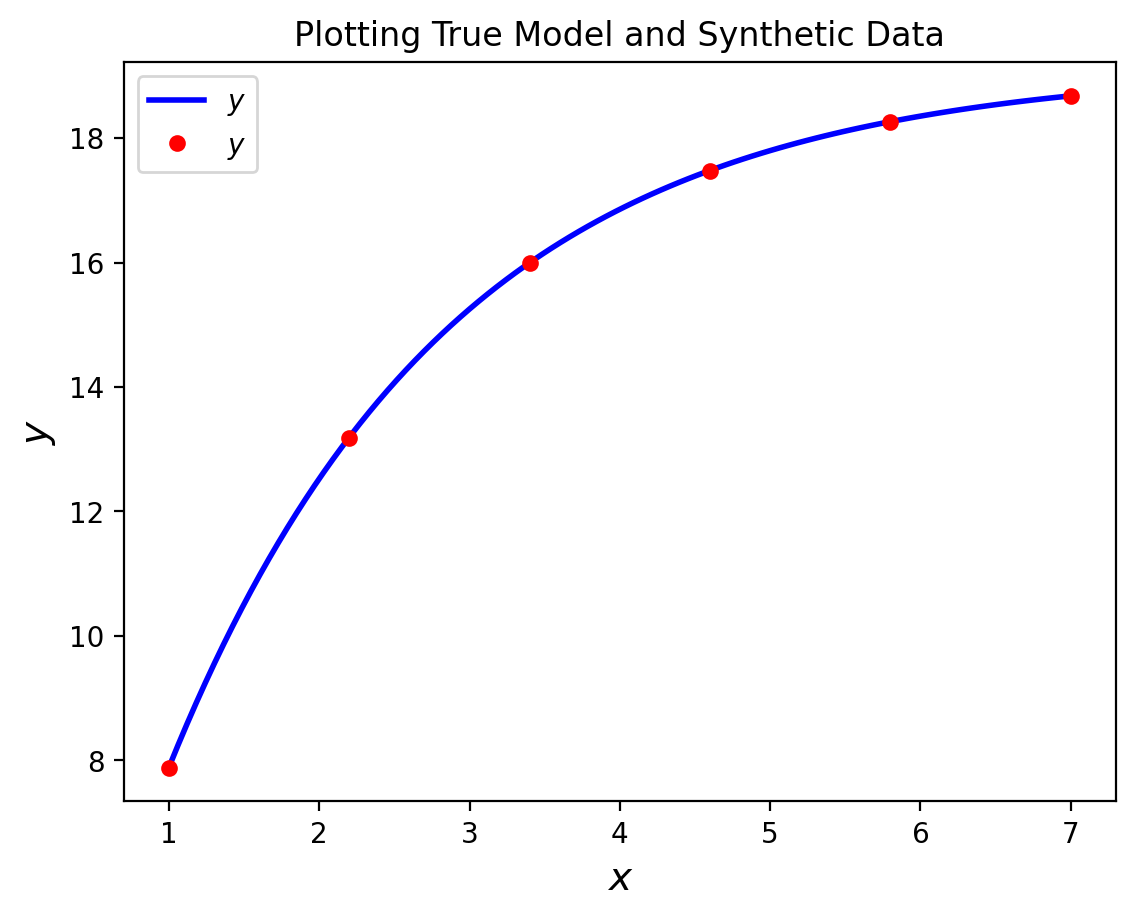

CPU times: total: 172 ms
Wall time: 201 ms


In [19]:
%%time

param_name_str = "t1t2"
indeces_to_consider = [0,1]

bounds_x = np.array([[1],[7]])
bounds_theta_l = [10, 0]
bounds_theta_u = [ 30, 1]
theta_ref = np.array([19.143, 0.5311]) 
theta_names = ['theta_1', 'theta_2']
theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

# Evaluate model and add noise based on assumed theta values
# This generates experimental data points
Xexp = np.array([1,2,3,4,5,7]).reshape(-1,1)
num_points = len(Xexp)
Yexp_org = np.array([8.3,10.3,19.0, 16.0,15.6,19.8])
Xexp = grid_sampling(num_points, bounds_x)
Yexp_org = np.array([ calc_mm_model(theta_ref, Xexp[i])  for i in range(len(Xexp)) ]).flatten()
noise = np.random.normal(size=len(Yexp_org), loc = 0, scale = 0.01)
Yexp = Yexp_org + noise
print(Yexp)
# Evaluate model based on the assumed experimental values
X = np.linspace(np.min(Xexp),np.max(Xexp),100).reshape(-1,1)
Y = calc_mm_model(theta_ref, X.reshape(-1,1))

# Compare the experiments to the true model
plt.plot(X,Y,'b-',linewidth=2,label=r"$y$")
plt.plot(Xexp,Yexp,'r.',markersize=10,label=r"$y$")
plt.title("Plotting True Model and Synthetic Data")
plt.xlabel(r"$x$",fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
plt.legend()
plt.show()

In [20]:
##New Cell

## define function that includes nonlinear model
def model(theta_guess, theta_ref, x, indeces_to_consider):
    '''
        """
    Creates Muller potential values given a guess for "a"
    Parameters
    ----------
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, Independent variable data (exp or pred)
    Returns
    -------
        y_model: ndarray, The simulated Muller potential given the guess
    '''
    #Define an array to store y values in
    y_data = []
    #Loop over all theta values
    for i in range(len(x)):
        #Create model coefficient from true space substituting in the values of param_space at the correct indeces
        model_coefficients = theta_ref.copy()
        #Replace coefficients a specified indeces with their theta_val counterparts
        model_coefficients[indeces_to_consider] = theta_guess              
        #Create y data coefficients
        y = calc_mm_model(model_coefficients, x[i])
        y_data.append(y)
        # print(model_coefficients, x[i], y)

    #Convert list to array and flatten array
    y_model = np.array(y_data).flatten()
    
    return y_model

print(model(theta_true, theta_true, Xexp, indeces_to_consider))

##New Cell

# Create a function to optimize, in this case, least squares fitting
def regression_func(theta_guess, theta_ref, x, indeces_to_consider, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    error = y - model(theta_guess, theta_ref, x, indeces_to_consider) #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

print(regression_func(theta_true, theta_true, Xexp, indeces_to_consider, Yexp))

#Create a function to define the SSE for any Theta vector on a heat map.
def sse_func(theta_guesses, theta_ref, indeces_to_consider, Xexp, Yexp):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all a_1 values
        yy: An D X N array of all a_2 values
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    #Initialize sse grid
    sse = np.zeros(len(theta_guesses))
    
    #For each guess
    for i in range(len(theta_guesses)):
        #Evaluate the model
        y_sim = model(theta_guesses[i], theta_ref, Xexp, indeces_to_consider)
        #Calculate SSE
        sse[i] = np.sum((y_sim - Yexp)**2)
     
    sse = sse.reshape(int(np.sqrt(len(theta_guesses))), -1).T
    
    return sse

print(sse_func([theta_true], theta_true, indeces_to_consider, Xexp, Yexp))

[ 7.88772268 13.19225088 15.99679453 17.47957769 18.26353621 18.67802093]
[-0.00738274 -0.01459008 -0.00412245 -0.00177777 -0.01122316 -0.00804828]
[[0.00047826]]


In [21]:
#Set seed and repeats
# seed = 4
# np.random.seed(seed)

## specify bounds
lower = np.array([bounds_theta_l[i] for i in indeces_to_consider] )
upper = np.array([bounds_theta_u[i] for i in indeces_to_consider] )
bounds = (lower, upper)
print(bounds)

## specify initial guesses
theta_guess = np.random.uniform(low=lower, high=upper, size=len(lower) )
print(theta_guess)

Solution = optimize.least_squares(regression_func, theta_guess, bounds=bounds, method='trf',
                                    args=(theta_true, Xexp.reshape(-1,1), indeces_to_consider, Yexp),verbose=0)

nlr_theta = Solution.x

print("Best Theta = ", nlr_theta)
print("theta_ref", theta_true)
Y_nlr_exp = model(nlr_theta, theta_true, Xexp, indeces_to_consider)
error = (Yexp - Y_nlr_exp)
print("SSE = ", np.sum(error**2))

(array([10,  0]), array([30,  1]))
[17.2871612   0.58510319]
Best Theta =  [19.13824359  0.53063483]
theta_ref [19.143   0.5311]
SSE =  0.00011032889302344628


In [22]:
#Create heat map data
#Create list of heat map theta data
heat_map_data_dict = {}

#Create a linspace for the number of dimensions and define number of points
dim_theta = len(theta_true_names)
dim_list = np.linspace(0, dim_theta-1, dim_theta)

#Create a list of all combinations (without repeats e.g no (1,1), (2,2)) of dimensions of theta
mesh_combos = np.array(list(combinations(dim_list, 2)), dtype = int)
n_points = 20

#Meshgrid set always defined by n_points**2
theta_set = np.tile(np.array(theta_true), (n_points**2, 1))

#Set x_vals
norm_x_vals = Xexp.reshape(-1,1)

#Loop over all possible theta combinations of 2
for i in range(len(mesh_combos)):
    #Create a copy of the true values to change the mehsgrid valus on
    theta_set_copy = np.copy(theta_set)
    #Set the indeces of theta_set for evaluation as each row of mesh_combos
    idcs = mesh_combos[i]
    #define name of parameter set as tuple ("param_1,param_2")
    data_set_name = (theta_true_names[idcs[0]], theta_true_names[idcs[1]])

    #Create a meshgrid of values of the 2 selected values of theta and reshape to the correct shape
    #Assume that theta1 and theta2 have equal number of points on the meshgrid
    theta1 = np.linspace(lower[idcs[0]], upper[idcs[0]], n_points)
    theta2 = np.linspace(lower[idcs[1]], upper[idcs[1]], n_points)
    theta12_mesh = np.array(np.meshgrid(theta1, theta2))
    theta12_vals = np.array(theta12_mesh).T.reshape(-1,2)

    #Set initial values for evaluation (true values) to meshgrid values
    theta_set_copy[:,idcs] = theta12_vals
    
    #Append data set to dictionary with name
    heat_map_data_dict[data_set_name] = theta_set_copy
    
hm_data_keys = list(heat_map_data_dict.keys())
# print(heat_map_data_dict[hm_data_keys[0]].shape)

True


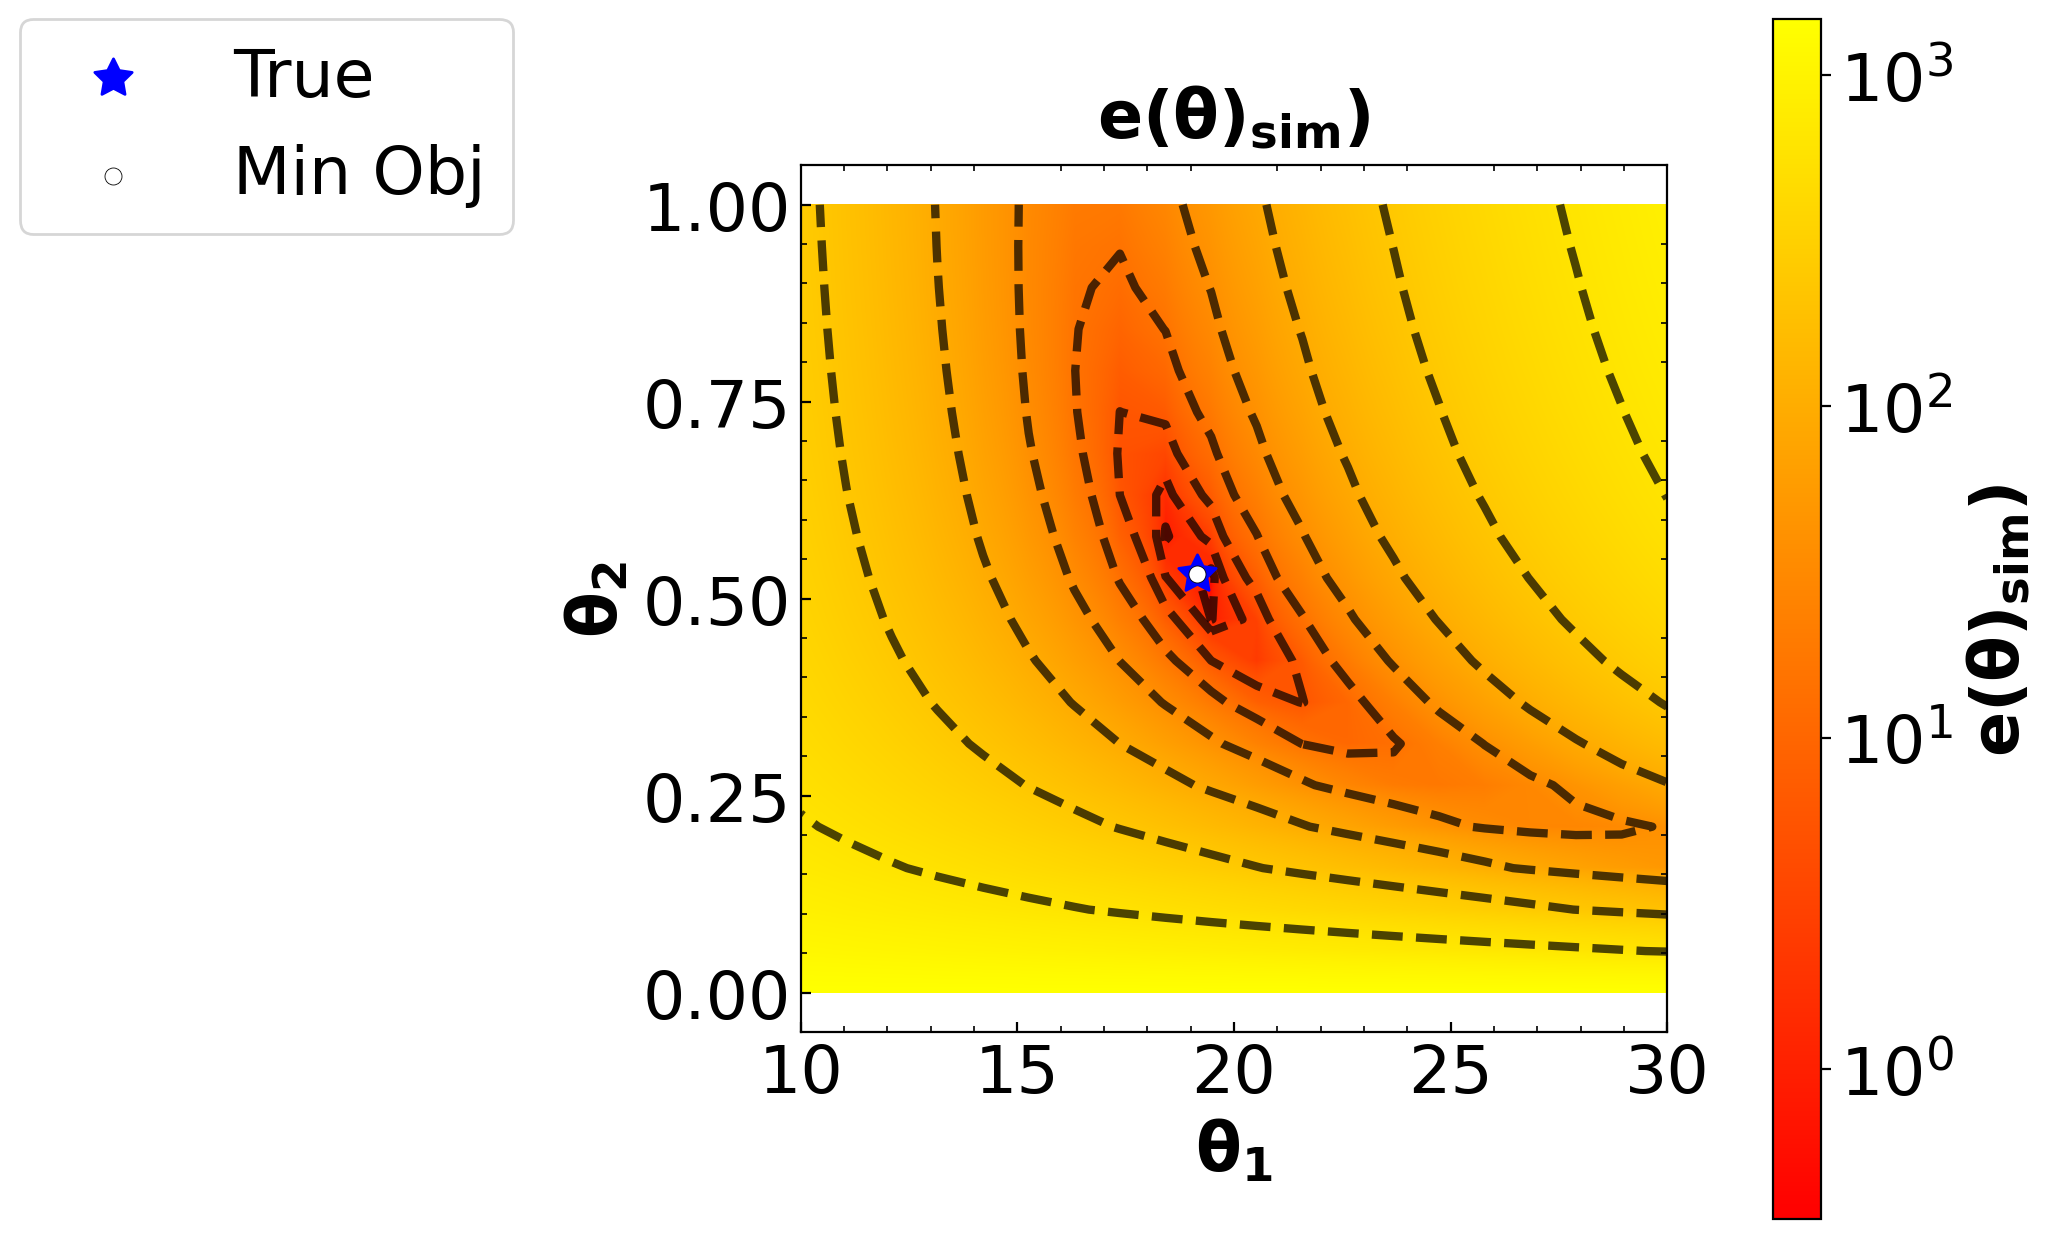

In [23]:
#New Cell
log_data = False
# save_figure = True
save_figure = False

#Get Number of pairs
combos = list(combinations(dim_list, 2))
pairs = len((list(combinations(dim_list, 2))))

#For each pair
for pair in range(pairs):
    #Make a meshgrid for each parameter
    idcs_to_plot = [int(combos[pair][i]) for i in range(len(combos[pair]))]
    theta_data = heat_map_data_dict[hm_data_keys[pair]].reshape(n_points, n_points, -1).T
    theta_mesh = np.take(theta_data, list(combos[pair]), axis=0)
    
    sse_sim = sse_func(heat_map_data_dict[hm_data_keys[pair]], theta_ref, indeces_to_consider, Xexp.reshape(-1,1), Yexp)
    param_names = theta_true_names[idcs_to_plot]
    
    title = "Heat Map Pair " + "-".join(map(str, param_names))
    title = None

    z = np.array([sse_sim])
    # print(np.amin(z), np.amax(z))
    if log_data == True:
        z_titles = ["ln("+ r"$\mathbf{e(\theta)_{sim}}$" + ")"]
        z = np.log(z)
    else:
        z_titles = [r"$\mathbf{e(\theta)_{sim}}$" + ")"]
    
#     z_save_names = ["sse_sim", "sse_nlr"]
#     path_end = '-'.join(z_save_names) 
    levels = [100]

    plot_dict = make_plot_dict(log_data, None, None, None, levels, save_path=None)
    plot_nlr_heat_maps(theta_mesh, z, theta_true, nlr_theta, z_titles, param_names, idcs_to_plot, plot_dict)

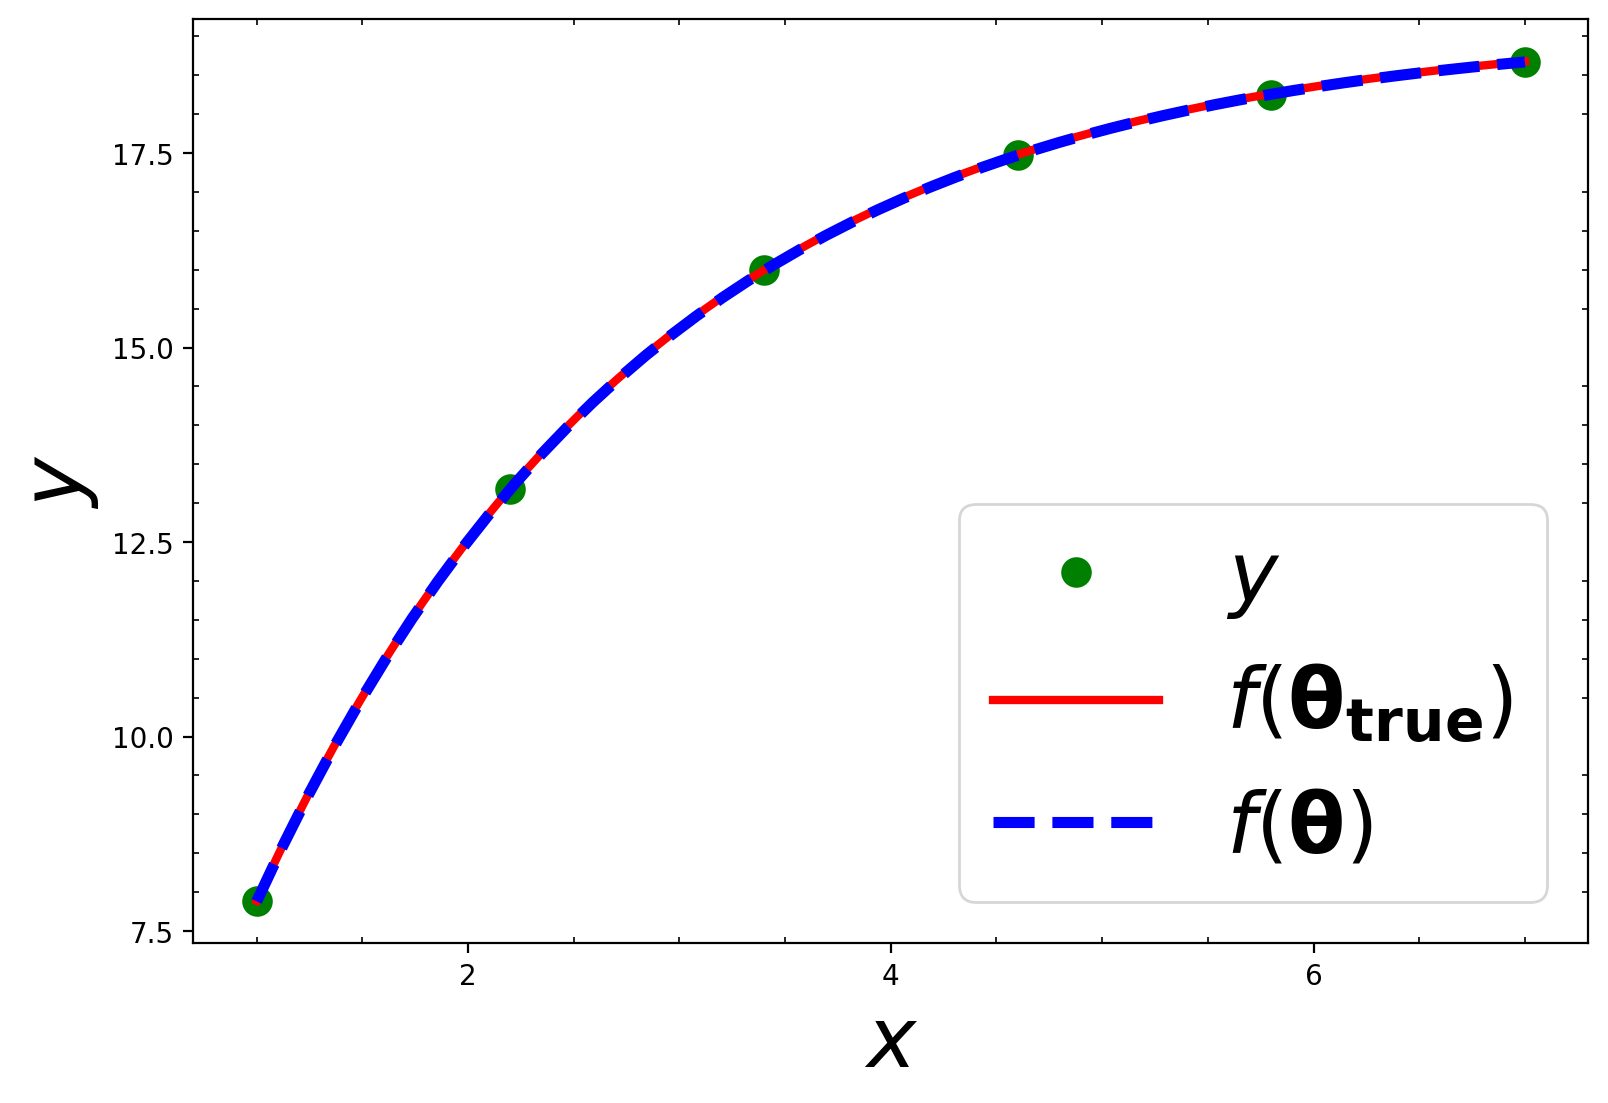

SSE =  0.00011032889302344628


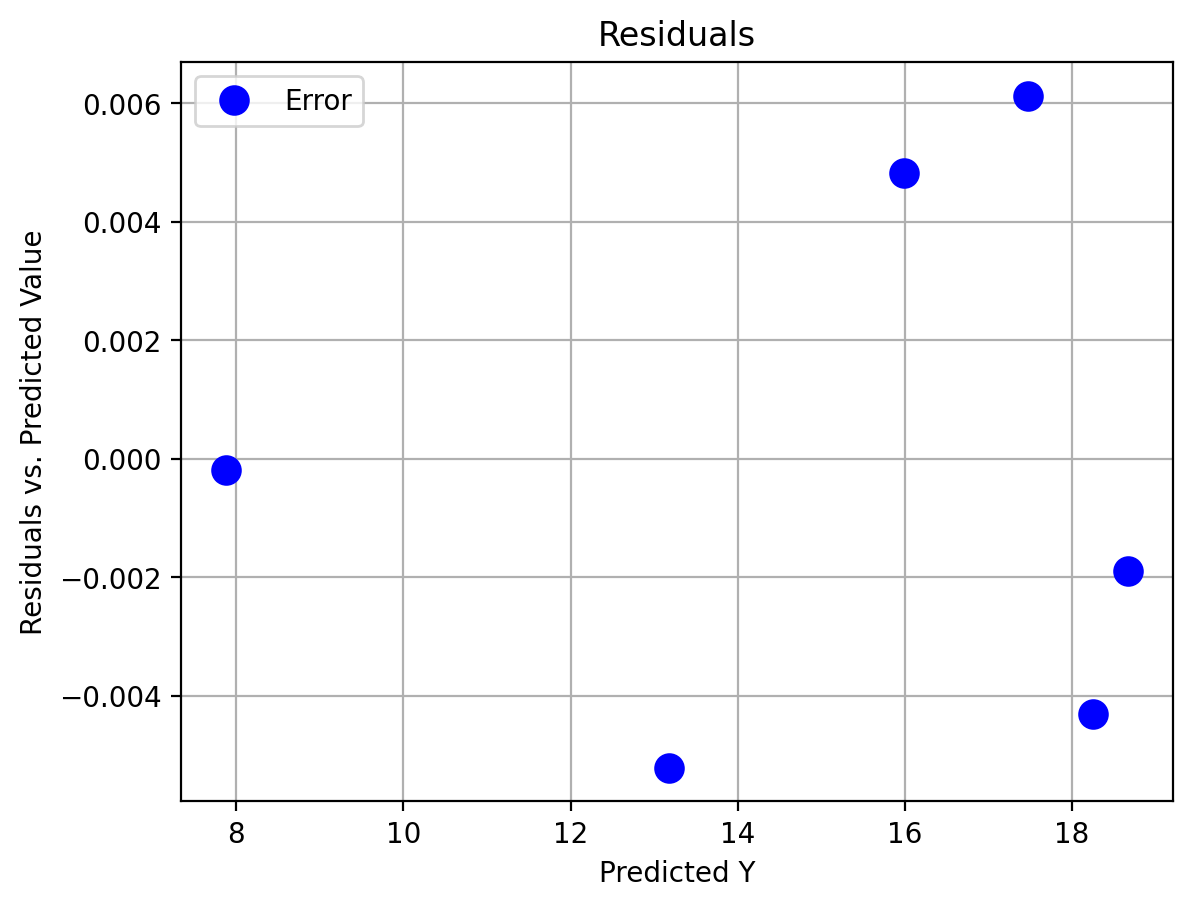

In [24]:
# create plot and compare predictions and experiments
X_pred = np.linspace(bounds_x[0], bounds_x[1]).reshape(-1,1)
Y_pred = model(nlr_theta, theta_true, X_pred, indeces_to_consider).flatten()
plt.figure(figsize = (9,6))
plt.plot(Xexp,Yexp,'.g',markersize=20,label=r'$y$')
plt.plot(X,Y,'r-',linewidth=3,label=r'$f(\mathbf{\theta_{true}})$')
plt.plot(X_pred,Y_pred,'--b',linewidth=4,label=r'$f(\mathbf{\theta})$')
# plt.title("Predictions with $\\theta = [0.994,-1.00]$ vs Synthetic Data")
# plt.title("Predictions with $\\theta = [0.802,-0.757]$ vs Synthetic Data")
plt.legend(loc = "lower right", fontsize=30) #(bbox_to_anchor=(1.04, 1), borderaxespad=0
plt.xlabel(r'$x$',fontsize=30,fontweight='bold')
plt.ylabel(r'$y$',fontsize=30,fontweight='bold')

plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
# plt.grid(True)

# plt.savefig("Figures/sim_true_comp_poster.png", dpi=300, bbox_inches='tight')
plt.show()


##New Cell

#Plot error
print("SSE = ", np.sum(error**2))
plt.plot(Y_nlr_exp,error,"b.",markersize=20, label = "Error")
plt.title("Residuals")
plt.xlabel('Predicted Y')
plt.ylabel('Residuals vs. Predicted Value')
plt.grid(True)
plt.legend()
plt.show()

In [16]:
#Jacobian and Uncertainty Analysis
print("Jacobian =\n")
print(Solution.jac)
sigre = (error.T @ error)/(len(error) - 2)
Sigma_theta2 = sigre * np.linalg.inv(Solution.jac.T @ Solution.jac)
print("Covariance matrix:\n",Sigma_theta2)
print("Det(Covar) = ", np.linalg.det(Sigma_theta2))

Jacobian =

[[ -0.41208186 -11.25521612]
 [ -0.68918849 -13.09051538]
 [ -0.83568496 -10.69530571]
 [ -0.91313244  -7.64983964]
 [ -0.95407621  -5.09920812]
 [ -0.97572172  -3.25351644]]
Covariance matrix:
 [[ 1.37883646e-04 -1.02210064e-05]
 [-1.02210064e-05  1.09735311e-06]]
Det(Covar) =  4.683807651920079e-11
